# Algorithme de SHOR

In [24]:
# pylint: disable=invalid-name
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

ImportError: cannot import name 'Aer' from 'qiskit' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/__init__.py)

## 1. Le Problème : La Recherche de Période

Considérons la fonction périodique :

$$ f(x) = a^x \bmod{N}$$

<details>
    <summary>Rappel : Opération Modulo & Arithmétique Modulaire (Cliquez pour développer)</summary>

L'opération modulo (abrégée 'mod') consiste simplement à trouver le reste de la division d'un nombre par un autre. Par exemple :

$$ 17 \bmod 5 = 2 $$

Puisque $17 \div 5 = 3$ avec un reste de $2$ (c'est-à-dire $17 = (3\times 5) + 2$). En Python, l'opération modulo est notée via le symbole <code>%</code>.

Ce comportement est utilisé dans <a href="https://fr.wikipedia.org/wiki/Arithm%C3%A9tique_modulaire">l'arithmétique modulaire</a>, où les nombres 'reviennent à zéro' après avoir atteint une certaine valeur (le module). En utilisant l'arithmétique modulaire, on pourrait écrire :

$$ 17 = 2 \pmod 5$$

Notez qu'ici le $\pmod 5$ s'applique à l'équation entière (puisqu'il est entre parenthèses), contrairement à l'équation précédente où il ne s'appliquait qu'au côté gauche de l'équation.
</details>

où $a$ et $N$ sont des entiers positifs, $a$ est inférieur à $N$, et ils n'ont pas de facteurs communs. La période, ou ordre ($r$), est le plus petit entier (non nul) tel que :

$$a^r \bmod N = 1 $$ 

Nous pouvons voir un exemple de cette fonction tracée sur le graphique ci-dessous. Notez que les lignes entre les points aident à visualiser la périodicité et ne représentent pas les valeurs intermédiaires entre les marqueurs x.

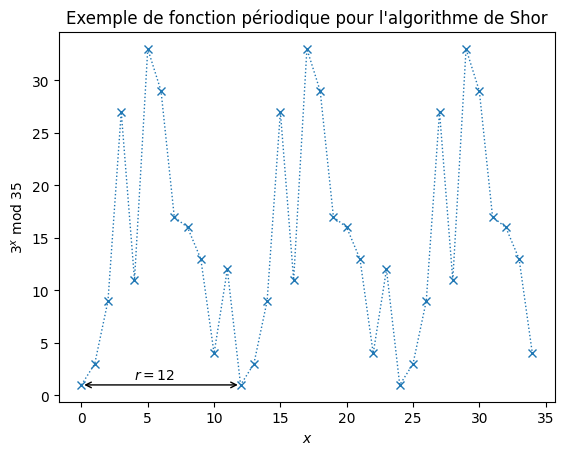

In [3]:
N = 35
a = 3

xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Exemple de fonction périodique pour l'algorithme de Shor")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Période introuvable, vérifier que a < N.')

## 2. La Solution

La solution de Shor consiste à utiliser l'estimation de phase quantique sur l'opérateur unitaire :

$$ U|y\rangle \equiv |ay \bmod N \rangle $$

Pour comprendre en quoi cela est utile, cherchons à quoi pourrait ressembler un état propre de U. Si nous commençons dans l'état $|1\rangle$, nous pouvons observer que chaque application successive de U va multiplier l'état de notre registre par $a \pmod N$, et après $r$ applications nous reviendrons à l'état $|1\rangle$. Par exemple, avec $a = 3$ et $N = 35$ :

$$\begin{aligned}
U|1\rangle &= |3\rangle & \\
U^2|1\rangle &= |9\rangle \\
U^3|1\rangle &= |27\rangle \\
& \vdots \\
U^{(r-1)}|1\rangle &= |12\rangle \\
U^r|1\rangle &= |1\rangle 
\end{aligned}$$

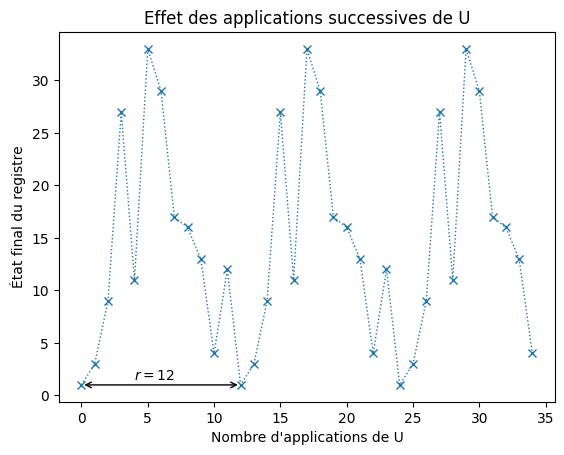

In [4]:
ax.set(xlabel='Nombre d\'applications de U',
       ylabel='État final du registre', 
       title="Effet des applications successives de U")
fig

## 2. La Solution (suite)

Ainsi, une superposition des états dans ce cycle ($|u_0\rangle$) serait un état propre de $U$ :

$$|u_0\rangle = \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{|a^k \bmod N\rangle} $$


<details>
    <summary>Cliquez pour développer : Exemple avec $a = 3$ et $N=35$</summary>

$$\begin{aligned}
|u_0\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + |3\rangle + |9\rangle \dots + |4\rangle + |12\rangle) \\[10pt]
U|u_0\rangle &= \tfrac{1}{\sqrt{12}}(U|1\rangle + U|3\rangle + U|9\rangle \dots + U|4\rangle + U|12\rangle) \\[10pt]
 &= \tfrac{1}{\sqrt{12}}(|3\rangle + |9\rangle + |27\rangle \dots + |12\rangle + |1\rangle) \\[10pt]
 &= |u_0\rangle
\end{aligned}$$
</details>


Cet état propre a une valeur propre de 1, ce qui n'est pas très intéressant. Un état propre plus intéressant pourrait être celui dans lequel la phase est différente pour chacun de ces états de base computationnels. Plus précisément, considérons le cas où la phase du $k^\text{ième}$ état est proportionnelle à $k$ :

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{r}}|u_1\rangle 
\end{aligned}
$$

<details>
    <summary>Cliquez pour développer : Exemple avec $a = 3$ et $N=35$</summary>

$$\begin{aligned}
|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i}{12}}|4\rangle + e^{-\tfrac{22\pi i}{12}}|12\rangle) \\[10pt]
U|u_1\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i}{12}}|9\rangle + e^{-\tfrac{4\pi i}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i}{12}}|12\rangle + e^{-\tfrac{22\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{\tfrac{-2\pi i}{12}}|3\rangle + e^{-\tfrac{4\pi i}{12}}|9\rangle + e^{-\tfrac{6\pi i}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i}{12}}|12\rangle + e^{-\tfrac{24\pi i}{12}}|1\rangle) \\[10pt]
U|u_1\rangle &= e^{\tfrac{2\pi i}{12}}|u_1\rangle
\end{aligned}$$

(On peut voir que $r = 12$ apparaît au dénominateur de la phase.)
</details>

Ceci est une valeur propre particulièrement intéressante car elle contient $r$. En fait, $r$ doit être inclus pour garantir que les différences de phase entre les $r$ états de base computationnels sont égales. Ce n'est pas le seul état propre avec ce comportement ; pour généraliser davantage, nous pouvons multiplier un entier $s$ à cette différence de phase, qui apparaîtra dans notre valeur propre :

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{r}}\sum_{k=0}^{r-1}{e^{-\tfrac{2\pi i s k}{r}}|a^k \bmod N\rangle}\\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{r}}|u_s\rangle 
\end{aligned}
$$

<details>
    <summary>Cliquez pour développer : Exemple avec $a = 3$ et $N=35$</summary>

$$\begin{aligned}
|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|1\rangle + e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|4\rangle + e^{-\tfrac{22\pi i s}{12}}|12\rangle) \\[10pt]
U|u_s\rangle &= \tfrac{1}{\sqrt{12}}(|3\rangle + e^{-\tfrac{2\pi i s}{12}}|9\rangle + e^{-\tfrac{4\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{20\pi i s}{12}}|12\rangle + e^{-\tfrac{22\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}\cdot\tfrac{1}{\sqrt{12}}(e^{-\tfrac{2\pi i s}{12}}|3\rangle + e^{-\tfrac{4\pi i s}{12}}|9\rangle + e^{-\tfrac{6\pi i s}{12}}|27\rangle \dots + e^{-\tfrac{22\pi i s}{12}}|12\rangle + e^{-\tfrac{24\pi i s}{12}}|1\rangle) \\[10pt]
U|u_s\rangle &= e^{\tfrac{2\pi i s}{12}}|u_s\rangle
\end{aligned}$$

</details>

Nous avons maintenant un état propre unique pour chaque valeur entière de $s$ où $0 \leq s \leq r-1$. Très commodément, si nous sommons tous ces états propres, les différentes phases s'annulent pour tous les états de base computationnels sauf $|1\rangle$ :

$$ \tfrac{1}{\sqrt{r}}\sum_{s=0}^{r-1} |u_s\rangle = |1\rangle$$

<details>
    <summary>Cliquez pour développer : Exemple avec $a = 7$ et $N=15$</summary>

Pour cela, nous examinerons un exemple plus petit où $a = 7$ et $N=15$. Dans ce cas $r=4$ :

$$\begin{aligned}
\tfrac{1}{2}(\quad|u_0\rangle &= \tfrac{1}{2}(|1\rangle \hphantom{e^{-\tfrac{2\pi i}{12}}}+ |7\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |4\rangle \hphantom{e^{-\tfrac{12\pi i}{12}}} + |13\rangle)\dots \\[10pt]
+ |u_1\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{2\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}4\pi i}{4}}|4\rangle + e^{-\tfrac{\hphantom{1}6\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_2\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{4\pi i}{4}}|7\rangle + e^{-\tfrac{\hphantom{1}8\pi i}{4}}|4\rangle + e^{-\tfrac{12\pi i}{4}}|13\rangle)\dots \\[10pt]
+ |u_3\rangle &= \tfrac{1}{2}(|1\rangle + e^{-\tfrac{6\pi i}{4}}|7\rangle + e^{-\tfrac{12\pi i}{4}}|4\rangle + e^{-\tfrac{18\pi i}{4}}|13\rangle)\quad) = |1\rangle \\[10pt]
\end{aligned}$$

</details>

Puisque l'état de base computationnel $|1\rangle$ est une superposition de ces états propres, cela signifie que si nous effectuons une QPE sur $U$ en utilisant l'état $|1\rangle$, nous mesurerons une phase :

$$\phi = \frac{s}{r}$$

Où $s$ est un entier aléatoire entre $0$ et $r-1$. Nous utilisons finalement l'algorithme des [fractions continues](https://fr.wikipedia.org/wiki/Fraction_continue) sur $\phi$ pour trouver $r$. 

Nous allons ensuite démontrer l'algorithme de Shor en utilisant les simulateurs de Qiskit. Pour cette démonstration, nous fournirons les circuits pour $U$ sans explication, mais dans la section 4, nous discuterons de la manière dont les circuits pour $U^{2^j}$ peuvent être construits efficacement.

## 3. Implémentation dans Qiskit

Dans cet exemple, nous allons résoudre le problème de recherche de période pour $a=7$ et $N=15$. Nous fournissons les circuits pour $U$ où :

$$U|y\rangle = |ay\bmod 15\rangle $$

sans explication détaillée. Pour créer $U^x$, nous répéterons simplement le circuit $x$ fois. Dans la section suivante, nous discuterons d'une méthode générale pour créer ces circuits efficacement. La fonction `c_amod15` retourne la porte U contrôlée pour `a`, répétée `power` fois.

In [5]:
def c_amod15(a, power):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' doit être 2,4,7,8,11 ou 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

Nous utiliserons 8 qubits

In [6]:
# Variables
N_COUNT = 8  # nombre de qubits
a = 7

Nous importons aussi le circuit pour la TFQ.

In [7]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Avec ces blocs de construction, nous pouvons facilement construire le circuit pour l'algorithme de Shor :

In [8]:
# Créer un QuantumCircuit avec N_COUNT qubits de comptage
# plus 4 qubits pour que U agisse dessus
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialiser les qubits de comptage
# dans l'état |+>
for q in range(N_COUNT):
    qc.h(q)

# Et le registre auxiliaire dans l'état |1>
qc.x(N_COUNT)

# Effectuer les opérations U contrôlées
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Effectuer la QFT inverse
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Mesurer le circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 signifie 'ne pas replier'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

Mesurons les résultats :

In [9]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

NameError: name 'Aer' is not defined

Puisque nous avons 8 qubits, ces résultats correspondent aux phases mesurées de :

In [10]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convertir la chaîne (base 2) en décimal
    phase = decimal/(2**N_COUNT)  # Trouver la valeur propre correspondante
    measured_phases.append(phase)
    # Ajouter ces valeurs aux lignes de notre tableau :
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Afficher les lignes dans un tableau
headers=["Sortie du Registre", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

NameError: name 'counts' is not defined

Nous pouvons maintenant utiliser l'algorithme des fractions continues pour tenter de trouver $s$ et $r$. Python possède cette fonctionnalité intégrée : nous pouvons utiliser le module `fractions` pour transformer un float en objet `Fraction`, par exemple :

In [10]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

Comme cela donne des fractions qui retournent le résultat exactement (dans ce cas, `0.6660000...`), cela peut produire des résultats complexes comme celui ci-dessus. Nous pouvons utiliser la méthode `.limit_denominator()` pour obtenir la fraction qui ressemble le plus à notre float, avec un dénominateur inférieur à une certaine valeur :

In [11]:
# Obtenir la fraction la plus proche de 0.666
# avec dénominateur < 15
Fraction(0.666).limit_denominator(15)

NameError: name 'Fraction' is not defined

Bien mieux ! L'ordre (r) doit être inférieur à N, donc nous allons définir le dénominateur maximum à `15` :

In [12]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Mesure de r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

NameError: name 'pd' is not defined

Nous pouvons voir que deux des valeurs propres mesurées nous ont donné le résultat correct : $r=4$, et nous pouvons observer que l'algorithme de Shor a une chance d'échouer. Ces mauvais résultats sont dus au fait que $s = 0$, ou parce que $s$ et $r$ ne sont pas premiers entre eux et qu'au lieu de $r$ nous obtenons un facteur de $r$. La solution la plus simple est de simplement répéter l'expérience jusqu'à obtenir un résultat satisfaisant pour $r$.

## 4. Exponentiation Modulaire

Vous avez peut-être remarqué que la méthode de création des portes $U^{2^j}$ en répétant $U$ croît exponentiellement avec $j$ et ne résultera pas en un algorithme polynomial en temps. Nous voulons une façon de créer l'opérateur :

$$ U^{2^j}|y\rangle = |a^{2^j}y \bmod N \rangle $$

qui croît polynomialement avec $j$. Heureusement, le calcul de :

$$ a^{2^j} \bmod N$$

de manière efficace est possible. Les ordinateurs classiques peuvent utiliser un algorithme connu sous le nom d'_élévation au carré répétée_ pour calculer une exponentielle. Dans notre cas, puisque nous ne traitons que des exponentielles de la forme $2^j$, l'algorithme d'élévation au carré répétée devient très simple :

In [13]:
def a2jmodN(a, j, N):
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [14]:
a2jmodN(7, 2049, 53)

47

Si un algorithme efficace est possible en Python, alors nous pouvons utiliser le même algorithme sur un ordinateur quantique. Malheureusement, bien qu'évoluant polynomialement avec $j$, les circuits d'exponentiation modulaire ne sont pas simples et constituent le goulot d'étranglement dans l'algorithme de Shor. Une implémentation adaptée aux débutants peut être trouvée dans la référence [1].

## 5. Factorisation à partir de la Recherche de Période

Tous les problèmes de factorisation ne sont pas difficiles ; nous pouvons repérer instantanément un nombre pair et savoir que l'un de ses facteurs est 2. En fait, il existe des [critères spécifiques](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.186-4.pdf#%5B%7B%22num%22%3A127%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C70%2C223%2C0%5D) pour choisir des nombres difficiles à factoriser, mais l'idée de base est de choisir le produit de deux grands nombres premiers.

Un algorithme de factorisation général vérifiera d'abord s'il existe un raccourci pour factoriser l'entier (le nombre est-il pair ? Le nombre est-il de la forme $N = a^b$ ?), avant d'utiliser la recherche de période de Shor pour le pire des cas. Puisque nous visons à nous concentrer sur la partie quantique de l'algorithme, nous passerons directement au cas où N est le produit de deux nombres premiers.

### Exemple : Factoriser 15

Pour voir un exemple de factorisation sur un petit nombre de qubits, nous allons factoriser 15, dont nous savons tous qu'il est le produit des nombres premiers pas si grands que ça 3 et 5.

In [15]:
N = 15

La première étape est de choisir un nombre aléatoire, $a$, entre $1$ et $N-1$:

In [16]:
np.random.seed(1) 
a = randint(2, 15)
print(a)

NameError: name 'randint' is not defined

Ensuite on vérifie rapidement s'il ne s'agit pas déjà d'un facteur non-trivial de $N$.

In [17]:
from math import gcd # greatest common divisor
gcd(a, N)

1

Parfait. Ensuite, nous réalisons l'algorithme de recherche d'ordre de Shor pour `a = 7` et `N = 15`. Rappelez-vous que la phase que nous mesurons sera $s/r$ où :

$$ a^r \bmod N = 1 $$

et $s$ est un entier aléatoire entre 0 et $r-1$.

In [18]:
def qpe_amod15(a):
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialiser les qubits de comptage dans l'état |+>
    qc.x(N_COUNT) # Et le registre auxiliaire dans l'état |1>
    for q in range(N_COUNT): # Effectuer les opérations U contrôlées
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Effectuer la QFT inverse
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simuler les résultats
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` indique au backend de sauvegarder chaque mesure dans une liste
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Lecture du Registre : " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Phase Correspondante : {phase}")
    return phase

À partir de cette phase, nous pouvons facilement trouver un $r$.

In [19]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

NameError: name 'Aer' is not defined

In [20]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

NameError: name 'Fraction' is not defined

Maintenant que nous avons $r$, nous pouvons potentiellement l'utiliser pour trouver un facteur de $N$. Puisque :

$$a^r \bmod N = 1 $$

alors :

$$(a^r - 1) \bmod N = 0 $$

ce qui signifie que $N$ doit diviser $a^r-1$. Et si $r$ est également pair, alors nous pouvons écrire :

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$

(si $r$ n'est pas pair, nous ne pouvons pas aller plus loin et devons réessayer avec une valeur différente de $a$). Il y a alors une forte probabilité que le plus grand commun diviseur de $N$ et de $a^{r/2}-1$, ou de $a^{r/2}+1$ soit un facteur propre de $N$ [2] :

In [21]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


La cellule ci-dessous répète l'algorithme jusqu'à ce que au moins un facteur de 15 soit trouvé. 

In [22]:
a = 7
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nTENTATIVE {ATTEMPT}:")
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Résultat : r = {r}")
    if phase != 0:
        # Les conjectures pour les facteurs sont pgcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Facteurs conjecturés : {guesses[0]} et {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # La conjecture est un facteur !
                print(f"*** Facteur non trivial trouvé : {guess} ***")
                FACTOR_FOUND = True


TENTATIVE 1:


NameError: name 'Aer' is not defined

In [23]:
# The cell below repeats the algorithm until at least one factor of 15
# is found
assert (3 in guesses) or (5 in guesses)